Step 0. Read in Data and Import Librarys

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For sentiment analysis
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from wordcloud import WordCloud
from textblob import TextBlob  

plt.style.use('ggplot')

# nltk.download('averaged_perceptron_tagger') # Necessary if never used before.
# nltk.download('maxent_ne_chunker') # Necessary if never used before.
# nltk.download('words') # Necessary if never used before.
# nltk.download('vader_lexicon') # Necessary if never used before.

In [49]:
# Read in Data
df = pd.read_csv('spiders\\mjsh_reviews.csv')

In [50]:
df.head()

,date,name,rating,review
0,03/22/2024,operafansri,4.0,Service is always excellent here. Food was go...
1,03/22/2024,Csanchez,5.0,1st time there and I will return. The dinner a...
2,03/22/2024,ShaquanaN,5.0,I should’ve listened and not wasted $200. The ...
3,03/18/2024,MollyS,5.0,"We had the best time, the food was incredible ..."
4,03/17/2024,RayG,5.0,Absolutely great dinner! Service was exceptio...


In [51]:
df.reset_index(inplace=True)
df.rename(columns={'index': 'ID'}, inplace=True)

## Quick EDA

In [52]:
grouped = df.groupby('date')['rating'].mean()
grouped


date
01/01/2008    4.000000
01/01/2010    4.000000
01/01/2011    4.500000
01/01/2012    4.800000
01/01/2013    3.000000
                ...   
12/31/2019    5.000000
12/31/2020    4.666667
12/31/2021    4.500000
12/31/2022    4.833333
12/31/2023    4.400000
Name: rating, Length: 3179, dtype: float64

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7156 entries, 0 to 7155
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      7156 non-null   int64  
 1   date    7156 non-null   object 
 2   name    7152 non-null   object 
 3   rating  7156 non-null   float64
 4   review  7156 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 279.7+ KB


In [54]:
df['rating'] = df['rating'].astype('int')

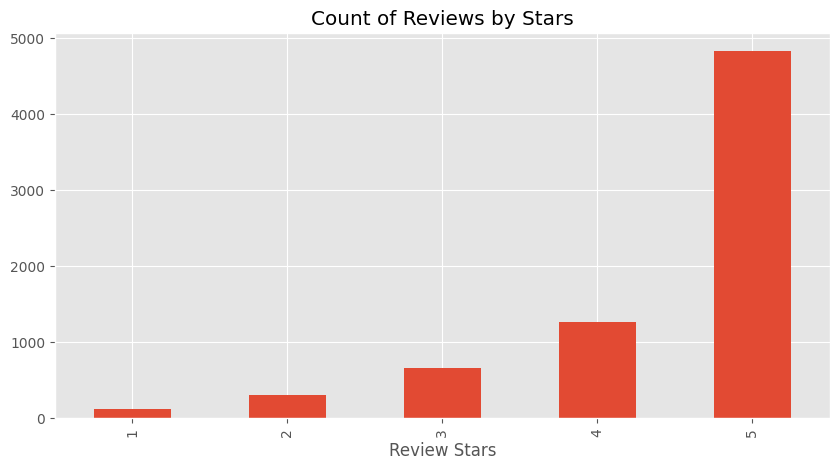

In [55]:
ax = df['rating'].value_counts().sort_index().plot(kind='bar', title='Count of Reviews by Stars', figsize=(10,5))
ax.set_xlabel("Review Stars")
plt.show()

## Basic NLTK

In [56]:
example = df['review'][3]
print(example)

We had the best time, the food was incredible and our server Brian was amazing! He was very attentive and gave us his suggestions and really made our dining experience great.


In [57]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['We', 'had', 'the', 'best', 'time', ',', 'the', 'food', 'was', 'incredible']

In [58]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('We', 'PRP'),
 ('had', 'VBD'),
 ('the', 'DT'),
 ('best', 'JJS'),
 ('time', 'NN'),
 (',', ','),
 ('the', 'DT'),
 ('food', 'NN'),
 ('was', 'VBD'),
 ('incredible', 'JJ')]

In [59]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  We/PRP
  had/VBD
  the/DT
  best/JJS
  time/NN
  ,/,
  the/DT
  food/NN
  was/VBD
  incredible/JJ
  and/CC
  our/PRP$
  server/NN
  (PERSON Brian/NNP)
  was/VBD
  amazing/VBG
  !/.
  He/PRP
  was/VBD
  very/RB
  attentive/JJ
  and/CC
  gave/VBD
  us/PRP
  his/PRP$
  suggestions/NNS
  and/CC
  really/RB
  made/VBD
  our/PRP$
  dining/JJ
  experience/NN
  great/JJ
  ./.)


## VADER Seniment Scoring

In [60]:
sia = SentimentIntensityAnalyzer()

In [61]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.693, 'pos': 0.307, 'compound': 0.9245}

In [62]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['review']
    myid = row['ID']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/7156 [00:00<?, ?it/s]

In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'ID'})
vaders = vaders.merge(df, how='left')

In [ ]:
# Now we have sentiment score and metadata
vaders.head()

,ID,neg,neu,pos,compound,date,name,rating,review
0,0,0.000,0.558,0.442,0.9638,03/22/2024,operafansri,4,Service is always excellent here. Food was go...
1,1,0.000,0.748,0.252,0.5719,03/22/2024,Csanchez,5,1st time there and I will return. The dinner a...
2,2,0.056,0.601,0.343,0.9815,03/22/2024,ShaquanaN,5,I should’ve listened and not wasted $200. The ...
3,3,0.000,0.693,0.307,0.9245,03/18/2024,MollyS,5,"We had the best time, the food was incredible ..."
4,4,0.000,0.610,0.390,0.9783,03/17/2024,RayG,5,Absolutely great dinner! Service was exceptio...


### Plot VADER results

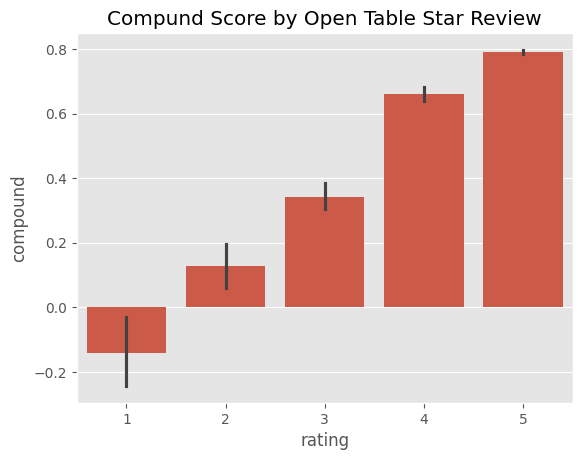

In [ ]:
ax = sns.barplot(data=vaders, x='rating', y='compound')
ax.set_title('Compund Score by Open Table Star Review')
plt.show()

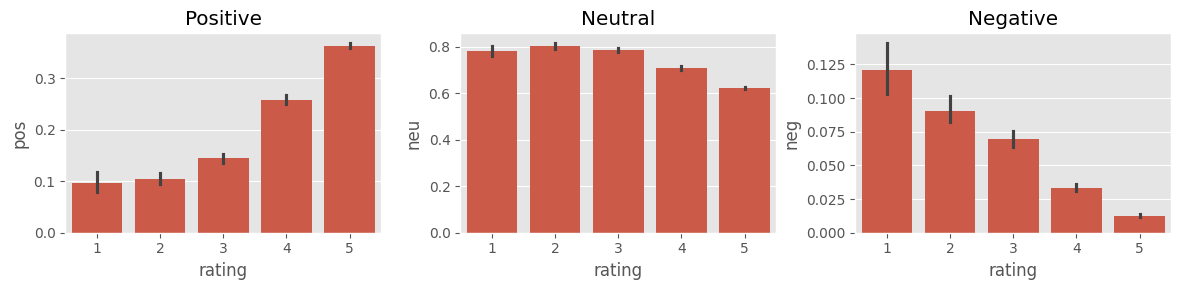

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

## Roberta Pretrained Model

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

c:\Users\tusab\OneDrive\Documentos\Data Science Projects\Web Scraping\MJSH\.venv\lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\tusab\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
# VADER results on example
print(example)
sia.polarity_scores(example)

We had the best time, the food was incredible and our server Brian was amazing! He was very attentive and gave us his suggestions and really made our dining experience great.


{'neg': 0.0, 'neu': 0.693, 'pos': 0.307, 'compound': 0.9245}

In [ ]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0016497425, 'roberta_neu': 0.005328693, 'roberta_pos': 0.99302155}


In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['review']
        myid = row['ID']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/7156 [00:00<?, ?it/s]

In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'ID'})
results_df = results_df.merge(df, how='left')
results_df

,ID,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,date,name,rating,review
0,0,0.000,0.558,0.442,0.9638,0.002834,0.012377,0.984789,03/22/2024,operafansri,4,Service is always excellent here. Food was go...
1,1,0.000,0.748,0.252,0.5719,0.001609,0.014465,0.983926,03/22/2024,Csanchez,5,1st time there and I will return. The dinner a...
2,2,0.056,0.601,0.343,0.9815,0.046678,0.106323,0.846999,03/22/2024,ShaquanaN,5,I should’ve listened and not wasted $200. The ...
3,3,0.000,0.693,0.307,0.9245,0.001650,0.005329,0.993022,03/18/2024,MollyS,5,"We had the best time, the food was incredible ..."
4,4,0.000,0.610,0.390,0.9783,0.001470,0.005942,0.992587,03/17/2024,RayG,5,Absolutely great dinner! Service was exceptio...
...,...,...,...,...,...,...,...,...,...,...,...,...
7151,7151,0.031,0.791,0.178,0.9758,0.015836,0.097404,0.886760,03/15/2008,OpenTable Diner,4,We had a reservation at 630...We were finally ...
7152,7152,0.119,0.881,0.000,-0.4015,0.862894,0.117143,0.019963,03/15/2008,TiffanyS,4,"It was so busy - even with a reservation, the ..."
7153,7153,0.000,0.655,0.345,0.9201,0.001662,0.006321,0.992017,03/14/2008,OpenTable Diner,5,We had a wonderful dining experience. The food...
7154,7154,0.000,0.501,0.499,0.6114,0.001827,0.017998,0.980175,03/14/2008,CLYDES,4,Heather our server was excellent!


### Combine and compare

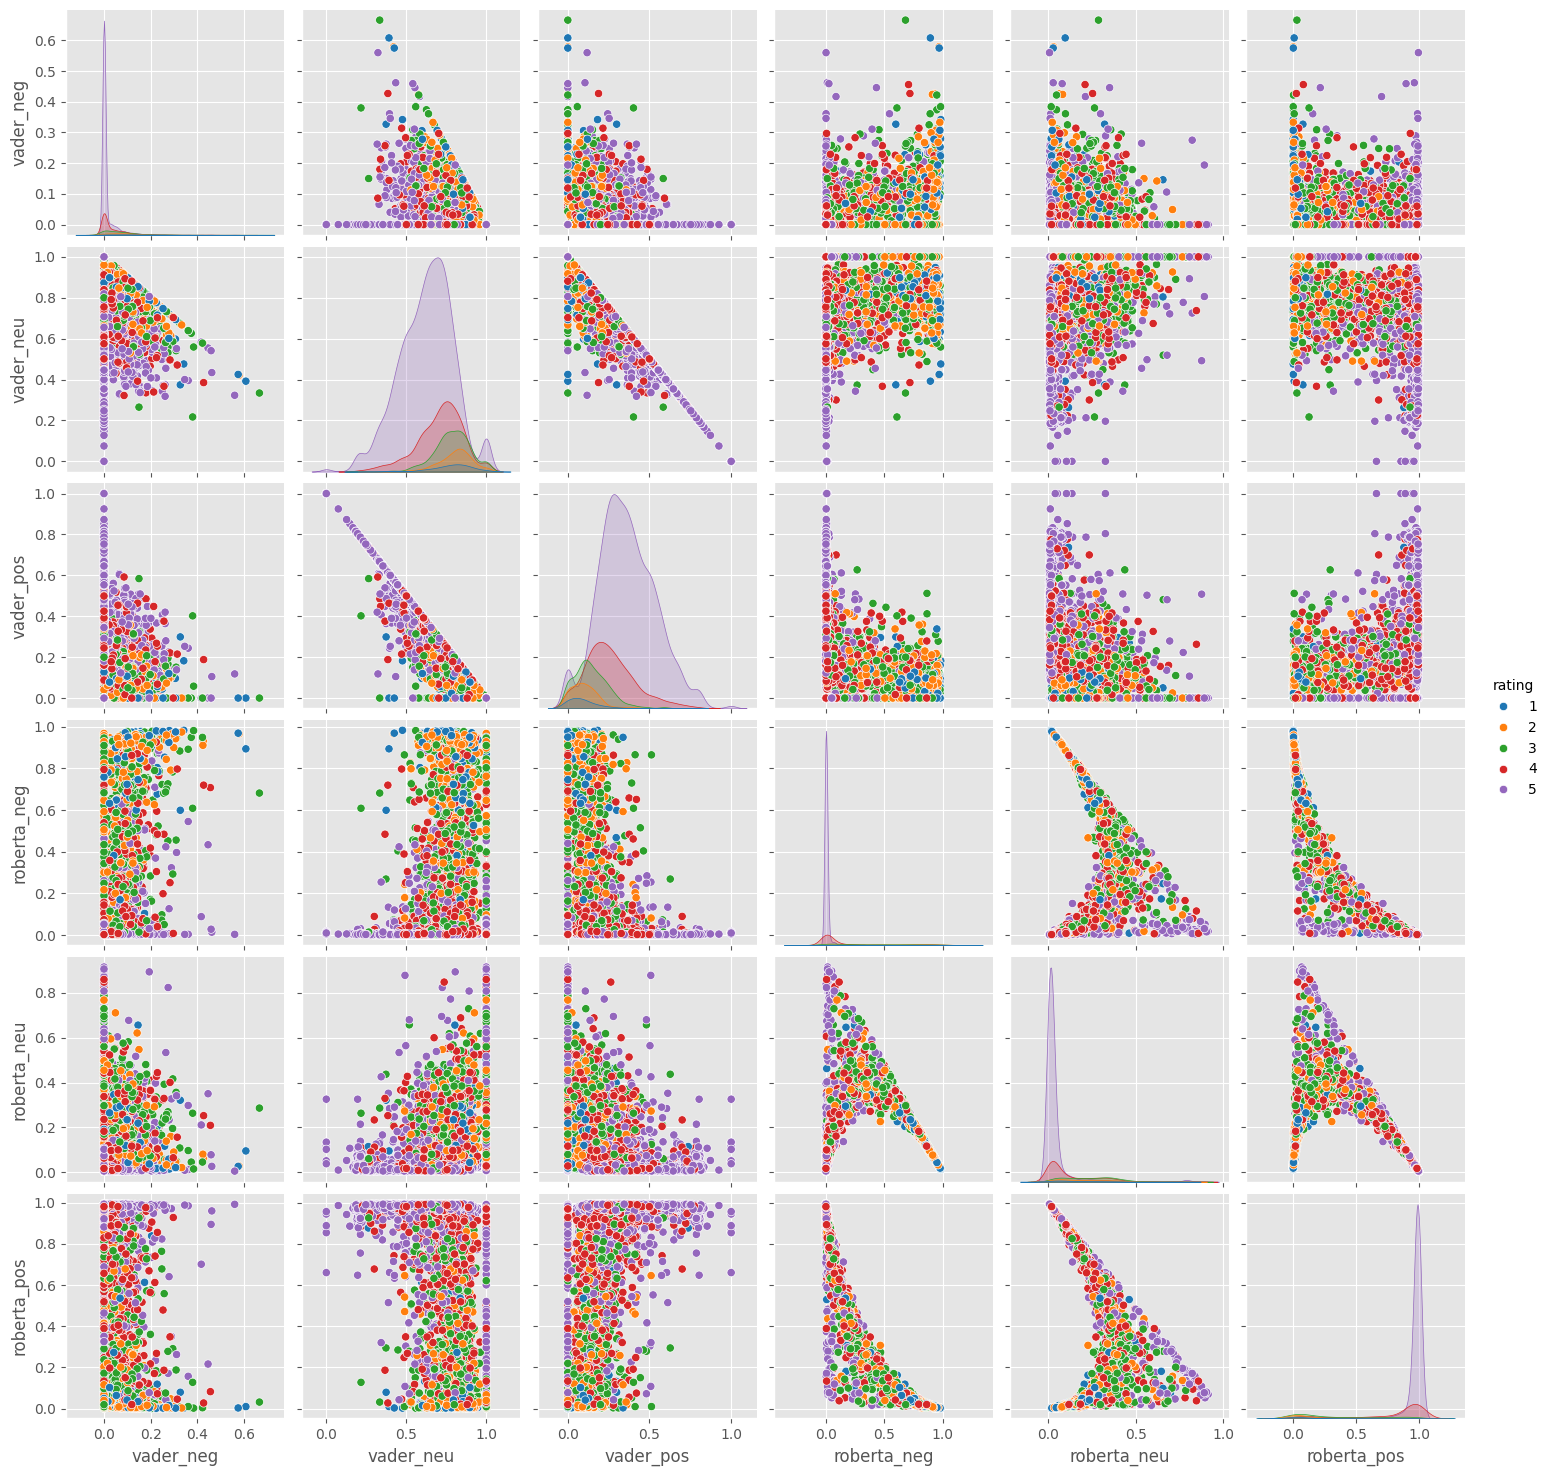

In [ ]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='rating',
            palette='tab10')
plt.show()

## WORKD CLOUD

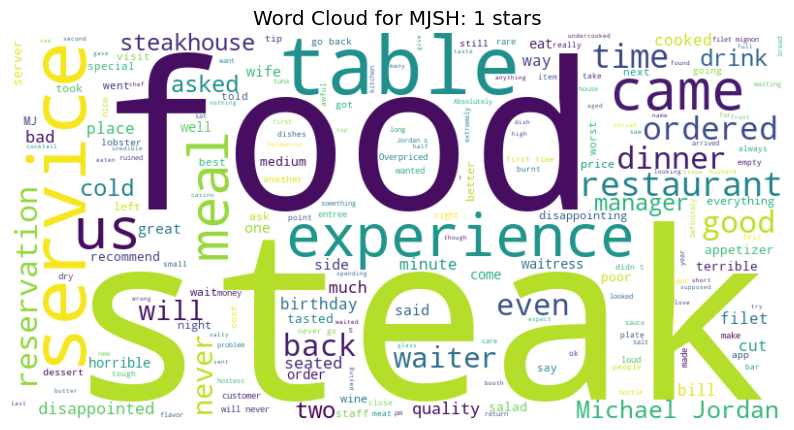

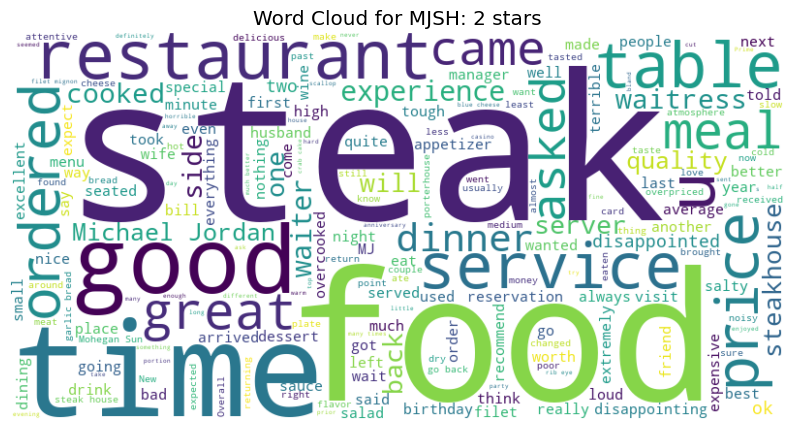

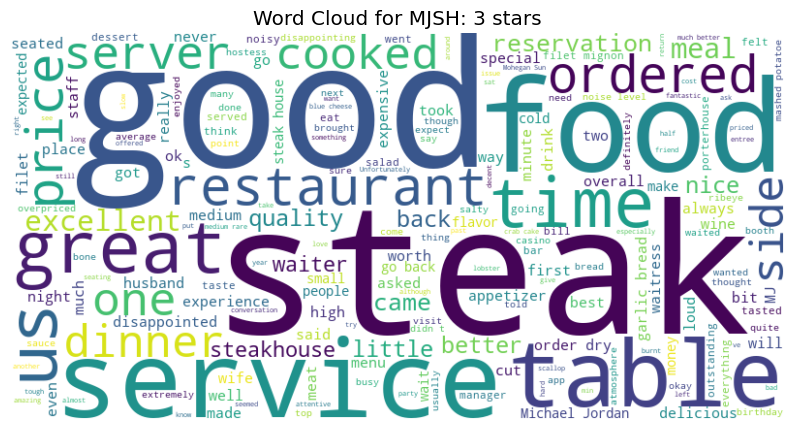

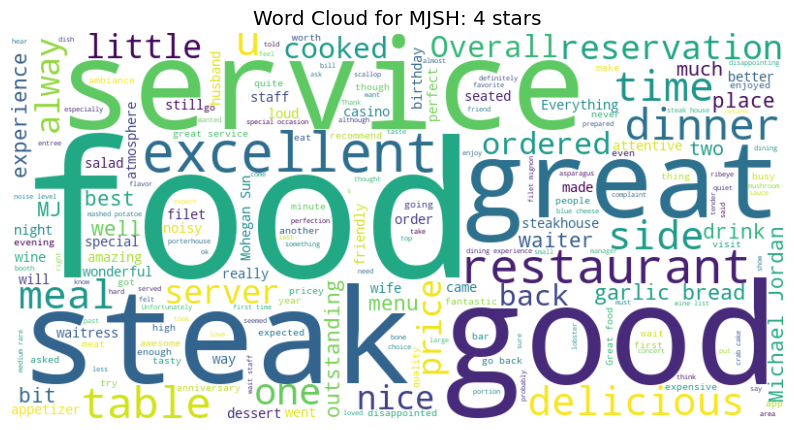

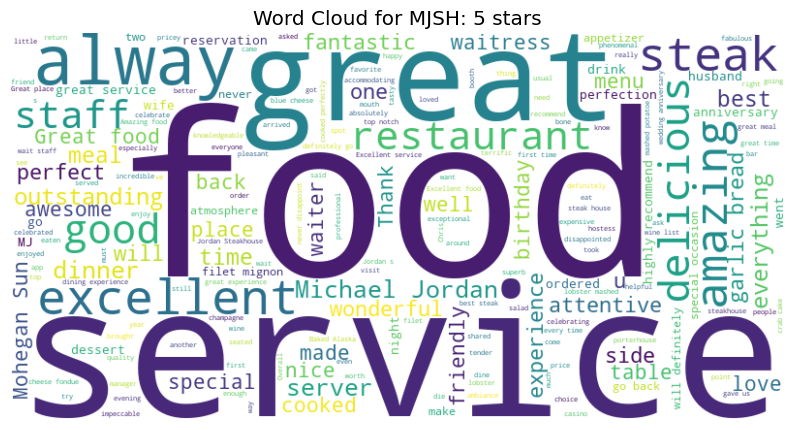

In [ ]:
for i in range(1,6):
    df_filtered = df[df['rating'] == i]

    # Assuming you have a DataFrame 'df' with a column 'review'
    # Extract the review text
    reviews_text = ' '.join(df_filtered['review'])

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(reviews_text)

    # Display the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide axes
    plt.title(f'Word Cloud for MJSH: {i} stars')
    plt.show()

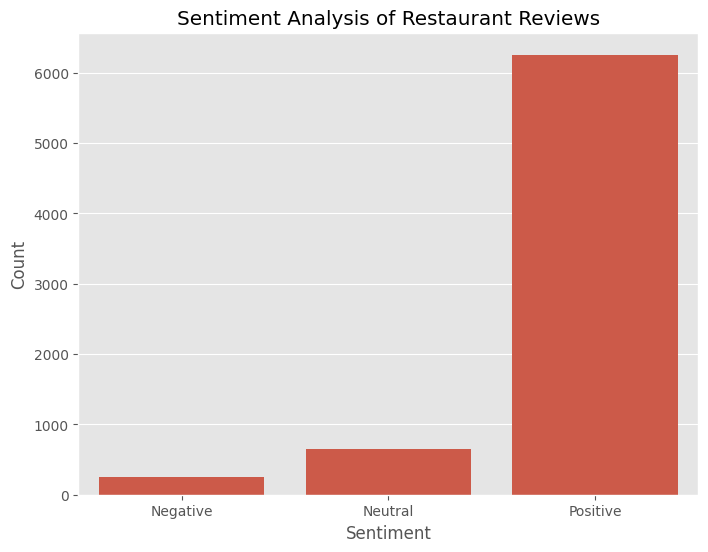

In [ ]:
# Assuming you have a DataFrame 'df' with a column 'Review Text'
# Extract the review text
reviews_text = df['review']

# Perform sentiment analysis on each review
sentiments = reviews_text.apply(lambda x: TextBlob(x).sentiment.polarity)

# Categorize sentiments
df['Sentiment'] = pd.cut(sentiments, bins=[-1, -0.1, 0.1, 1], labels=['Negative', 'Neutral', 'Positive'])

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=df)
plt.title('Sentiment Analysis of Restaurant Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

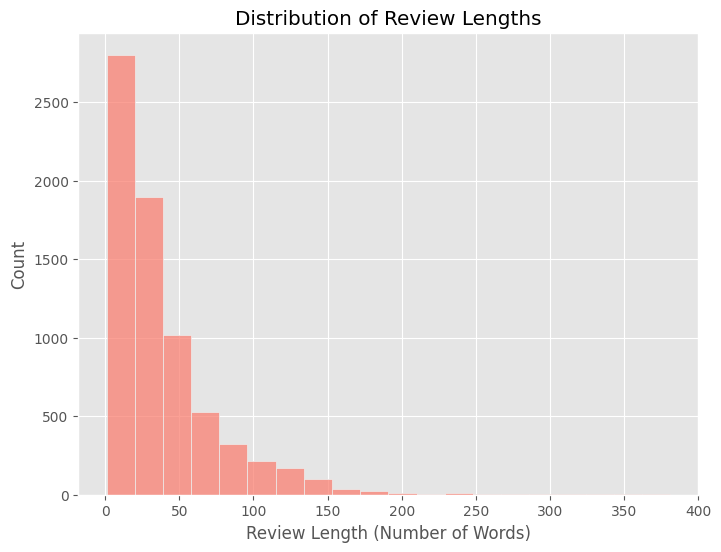

In [ ]:
# Calculate review lengths
df['Review Length'] = df['review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 6))
sns.histplot(df['Review Length'], bins=20, kde=False, color='salmon')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (Number of Words)')
plt.ylabel('Count')
plt.show()